# Annexe Projet TER et Explorations supplementaires 

Mehdi Chakhchoukh & Quentin Lemasson

Dataset and Subject:
https://www.kaggle.com/siddhadev/atis-dataset-from-ms-cntk/notebook

Page de sujet:
https://allauzen.github.io/cours/M1-TER-NNET/

# Mise en place du l'environement de travail:

(charger le dataset, compilé les fonctions faites dans le notebook principal et cree les modèle final(15) )

In [1]:
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# imports nécessaires pour l'aprentissage (réseau récurrent)

import torch  # Torch + quelques raccourcis
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1) # Pour la reproduction stable des expériences. 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("input/atis"))

import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.patches as mpatches
import pandas as pd

['atis.dict.intent.csv', 'atis.dict.slots.csv', 'atis.dict.vocab.csv', 'atis.test.intent.csv', 'atis.test.pkl', 'atis.test.query.csv', 'atis.test.slots.csv', 'atis.train.intent.csv', 'atis.train.pkl', 'atis.train.query.csv', 'atis.train.slots.csv']


In [2]:
import pickle

DATA_DIR="input/atis"

def load_ds(fname='atis.train.pkl'):
    with open(fname, 'rb') as stream:
        ds,dicts = pickle.load(stream)
    print('Done  loading: ', fname)
    print('      samples: {:4d}'.format(len(ds['query'])))
    print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
    print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
    print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds,dicts

In [3]:
print("Pour l'entrainement")
train_ds, dicts = load_ds(os.path.join(DATA_DIR,'atis.train.pkl'))
print("Pour les tests")
test_ds, dicts  = load_ds(os.path.join(DATA_DIR,'atis.test.pkl'))

Pour l'entrainement
Done  loading:  input/atis\atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Pour les tests
Done  loading:  input/atis\atis.test.pkl
      samples:  893
   vocab_size:  943
   slot count:  129
 intent count:   26


In [4]:
t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids','intent_ids']) # token to ids / slots to ids / intent to ids
i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i]) # ids to token /ids to slots /ids to intent 
query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels']) # query = les phrases // slots = les etiquettes /// intent = le sens des phrases 
testQuery, testSlots, testIntent =  map(test_ds.get, ['query', 'slot_labels', 'intent_labels']) # query = les phrases // slots = les etiquettes /// intent = le sens des phrases
for i in range(5):
    print('{:4d}:{:>15}: {}'.format(i, i2in[intent[i][0]],
                                    ' '.join(map(i2t.get, query[i]))))
    for j in range(len(query[i])):
        print('{:>33} {:>40}'.format(i2t[query[i][j]],
                                     i2s[slots[i][j]]  ))
    print('*'*74)
    


   0:         flight: BOS i want to fly from boston at 838 am and arrive in denver at 1110 in the morning EOS
                              BOS                                        O
                                i                                        O
                             want                                        O
                               to                                        O
                              fly                                        O
                             from                                        O
                           boston                      B-fromloc.city_name
                               at                                        O
                              838                       B-depart_time.time
                               am                       I-depart_time.time
                              and                                        O
                           arrive                                

In [5]:
def countSentences(query):
    return len(query)

def countWords(query):
    res=0
    for sent in query:
        for word in sent:
            res+=1
    return res

In [6]:
##Fonction qui cree un vocabilaire pour un set donné
def makeVocabOf(Set):
    dic = {}
    for sentence in Set:
                for word in sentence:
                    if word in dic:
                        dic[word]+=1
                    else:
                        dic[word]=1
    return dic

In [7]:
class RecurrentTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(RecurrentTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.à
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Cette fonction est donnée mais il faut bien la comprendre
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.softmax(tag_space, dim=1)
        return tag_scores
    
def makeModel(EMBEDDING, HIDDEN, ep):
    EMBEDDING_DIM = EMBEDDING
    HIDDEN_DIM = HIDDEN
    foomodel = RecurrentTagger(EMBEDDING_DIM ,HIDDEN_DIM , len(t2i), len(s2i))

    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(foomodel.parameters(), lr=0.01)


    ########
    losses = list()
    for epoch in range(ep):
        #print("###################",epoch,"############################")
        i=0
        epoch_acc = 0
        nb_mots = 0
        epoch_loss = 0 
        for example in query:

            foomodel.zero_grad()                       #mise à zéro du gradient
            foomodel.hidden = foomodel.init_hidden()   #mise à zéro des couches cachées

            outp = foomodel(torch.LongTensor(example)) #définition de l'output du modèle
            targets = torch.LongTensor(slots[i])       #définition des solutions

            loss = loss_function(outp, targets)        #calcul de la loss
            loss.backward()                            #calcul des gradients de la loss
            optimizer.step()                           #passer une étape dans l'optimiseur
            epoch_loss+=loss
            i+=1

            #print("TEST ", i)
            #print(outp.shape)
            #print(outp[0].shape)

            total_accuracy = 0
            j_max = 0
            total_mots = len(targets)
            correct = 0
            for j,w in enumerate(example):
                predict = outp[j].max(-1)[1]
                #print("-Predicted indice:", predict)
                #print("-Predicted slot:", i2s.get(predict.item()), " for ", i2s.get(targets[j].item()))
                #print("For: ", targets[j] )
                #print("-Likelyhood of slot:", outp[j].max(-1)[0])
                correct += (predict == targets[j]).sum().item()
            epoch_acc+=correct
            nb_mots += total_mots
        #print(epoch, "précision : ", epoch_acc*100/nb_mots, "%")
        losses.append(epoch_loss)
        #print("###################",epoch,"############################")
        if(epoch >= ep-1 ):
            print(epoch_acc*100/nb_mots)
            
    return foomodel


In [8]:
final15 = makeModel(15,15,10)

89.17757374487205


In [137]:
#Fonction qui fait et affiche la prediction d'un model donnée sur une phrase donnée 
def ShowPrediction(model, sent,targets):
    total =0
    success = 0
    res=[]
    outp = model(torch.LongTensor(sent))
    for j,w in enumerate(sent):
        predict = outp[j].max(-1)[1]
        res.append(predict)
        if(predict.item() == targets[j].item()):
            success +=1
        total+=1
        
        print("Word:",i2t.get(sent[j].item()))
        print("-Indice predit:", predict)
        print("-Tag predit:", i2s.get(predict.item()), " pour ", i2s.get(targets[j].item()))
        print("-Probabilité de prediction:", outp[j].max(-1)[0])
        print("'Predictions Réussites: ",success,"/",total) 
        print()
    return res

In [138]:
#Trouver des phrases de taille xx
for i in range(500):
    if(len(testQuery[i])==7):
        print(len(testQuery[i]),"  ",i)

7    41
7    175
7    178
7    181
7    230
7    252
7    280
7    342
7    346
7    362
7    452
7    453


In [139]:
#Changer la valeur de phrase pour tester des phrases differentes
phrase = 181
ShowPrediction(final15,testQuery[phrase],testSlots[phrase])

Word: BOS
-Indice predit: tensor(128)
-Tag predit: O  pour  O
-Probabilité de prediction: tensor(1., grad_fn=<MaxBackward0>)
'Predictions Réussites:  1 / 1

Word: what
-Indice predit: tensor(128)
-Tag predit: O  pour  O
-Probabilité de prediction: tensor(1.0000, grad_fn=<MaxBackward0>)
'Predictions Réussites:  2 / 2

Word: flights
-Indice predit: tensor(128)
-Tag predit: O  pour  O
-Probabilité de prediction: tensor(1.0000, grad_fn=<MaxBackward0>)
'Predictions Réussites:  3 / 3

Word: depart
-Indice predit: tensor(128)
-Tag predit: O  pour  O
-Probabilité de prediction: tensor(1., grad_fn=<MaxBackward0>)
'Predictions Réussites:  4 / 4

Word: from
-Indice predit: tensor(128)
-Tag predit: O  pour  O
-Probabilité de prediction: tensor(1.0000, grad_fn=<MaxBackward0>)
'Predictions Réussites:  5 / 5

Word: baltimore
-Indice predit: tensor(48)
-Tag predit: B-fromloc.city_name  pour  B-fromloc.city_name
-Probabilité de prediction: tensor(1.0000, grad_fn=<MaxBackward0>)
'Predictions Réussites: 

[tensor(128),
 tensor(128),
 tensor(128),
 tensor(128),
 tensor(128),
 tensor(48),
 tensor(128)]

# Debut d'exploration annexe

## Ambiguité du langage

In [9]:
##Fucntion that makes a vocab with all the tags that have been associated with each word in a given set
def Words_label_list(query, slots):
    dic = {}
    for sentence, labels in zip(query,slots):
                for i in range(len(sentence)): 
                    if sentence[i] in dic:
                        if labels[i] in dic[sentence[i]]:
                            dic[sentence[i]][labels[i]]+=1
                        else:
                            dic[sentence[i]][labels[i]]=1
                    else:
                        dic[sentence[i]] = {}
                        dic[sentence[i]][labels[i]]=1
    return dic

#Function that returns the ambiguity of a word in a given set (accordking to how many values a given word can have)
def wordAmbiguity(word, wordLabelList , vocab):
    total = vocab[word]
    maximum = max(wordLabelList[word], key=wordLabelList[word].get)
    return round((1-wordLabelList[word][maximum]/total)*100,3)

#Function that prints the ambiguity for all the words of a vocab
def print_WAmbiguity_for_Set(wordLabelList , vocab):
    for word in list(vocab.keys()):
        print(word,":",wordAmbiguity(word,wordLabelList,vocab))

#Function that returns the ambiguity of a set
def setAmbiguity(wordLabelList , vocab):
    if (len(wordLabelList) != len(vocab)):
        print("!WARNING!: Possibility of mismatched dictionaries")
    amb = 0
    total=0
    for word in list(vocab.keys()):
        amb  += wordAmbiguity(word, wordLabelList , vocab)* vocab[word]
        total += vocab[word]
    return round(amb/total,3)


In [10]:
trainVocab = makeVocabOf(query)
testVocab  = makeVocabOf(testQuery)

In [11]:
wllTrain = Words_label_list(query,slots)
wllTest  = Words_label_list(testQuery,testSlots)

In [12]:
print("######################################")
print("Ambiguité du training set ", setAmbiguity(wllTrain,trainVocab),'%')
print("Ambiguité du testing  set ", setAmbiguity(wllTest,testVocab),'%')
print("######################################")

######################################
Ambiguité du training set  10.293 %
Ambiguité du testing  set  10.87 %
######################################


In [13]:
def separation_Nombre_sens(wll):
    dic = {}
    for e in wll.keys():
        elem = len(wll.get(e))
        
        if elem in dic:
            dic[elem]+=1
        else:
            dic[elem] =1
    return dic

##Function that sorts the vocab so that we can observe the most and least used words
def dictToSortedList(dic): 
    return sorted(dic.items(), key=lambda kv: kv[1], reverse = True)

In [14]:
sens_separ_train = separation_Nombre_sens(wllTrain)
sens_separ_test = separation_Nombre_sens(wllTest)

for k in sens_separ_train.keys():
    if k not in sens_separ_test:
        sens_separ_test[k] = 0

print(sens_separ_train)
print(sens_separ_test)

{1: 649, 9: 3, 2: 102, 8: 2, 7: 9, 6: 8, 3: 63, 4: 29, 5: 26}
{1: 308, 2: 74, 5: 12, 4: 20, 3: 34, 7: 1, 9: 0, 8: 0, 6: 0}


In [15]:
train_sep = dictToSortedList(sens_separ_train)
test_sep = dictToSortedList(sens_separ_test)

print(train_sep)
print(test_sep)

name=[]
train_sep_values=[]
test_sep_values =[]

for e in train_sep:
    train_sep_values.append(e[1])
    name.append(e[0])
    
for e in test_sep:
    test_sep_values.append(e[1])

[(1, 649), (2, 102), (3, 63), (4, 29), (5, 26), (7, 9), (6, 8), (9, 3), (8, 2)]
[(1, 308), (2, 74), (3, 34), (4, 20), (5, 12), (7, 1), (9, 0), (8, 0), (6, 0)]


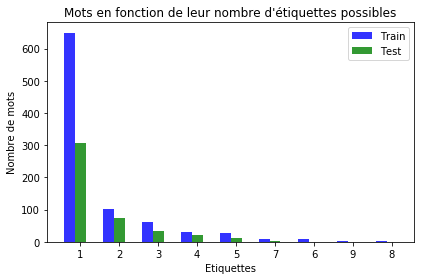

In [167]:
# data to plot
n_groups = len(name)
names= name
sepTraing = np.array(train_sep_values)
setTest = np.array(test_sep_values)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.28
opacity = 0.8

rects1 = plt.bar(index, sepTraing, bar_width, alpha=opacity,
color='b',
label='Train')

rects2 = plt.bar(index + bar_width, setTest, bar_width,
alpha=opacity,
color='g',
label='Test')

plt.xlabel('Etiquettes')
plt.ylabel('Nombre de mots')
plt.title("Mots en fonction de leur nombre d'étiquettes possibles")
plt.xticks(index + bar_width, (names))
plt.legend()

plt.tight_layout()
plt.show()


# Analyse des Erreurs 

In [17]:
def getError_sentence(model, sent,targets):
    error={}
    total =0
    success = 0
    res=[]
    outp = model(torch.LongTensor(sent))
    for j,w in enumerate(sent):
        predict = outp[j].max(-1)[1]
        res.append(predict)
        if(predict.item() == targets[j].item()):
            success +=1
        else:
            e = i2s.get(predict.item())+"//"+i2s.get(targets[j].item())
            if e in error:
                error[e]+=1
            else:
                error[e]=1
        
        total+=1
        
        #print("-Indice predit:", predict)
        #print("-Tag predit:", i2s.get(predict.item()), " pour ", i2s.get(targets[j].item()))
        #print("-Probabilité de prediction:", outp[j].max(-1)[0])
        #print("'Predictions Réussites: ",success,"/",total) 
        #print()
    return error


In [18]:
#Changer la valeur de phrase pour tester des phrases differentes
phrase = 354
getError_sentence(final15,testQuery[phrase],testSlots[phrase])

{'O//B-cost_relative': 1, 'I-toloc.city_name//I-fromloc.city_name': 1}

In [19]:
def mergeDict(dic1,acc):
    
    for e in dic1:
        if e in acc:
            acc[e]+= dic1[e]
        else:
            acc[e]=0
            acc[e]+= dic1[e]
    return acc

def getError_set(model,query,target):
    res ={}
    for sent,tar in zip(query,target):
        dic = getError_sentence(model,sent,tar)
        mergeDict( dic , res )
    return res
            

In [20]:
#mergeDict({'test':1},{'test':1})
training_error = getError_set(final15,query,slots)
sorted_training_error = dictToSortedList(training_error)

testing_error = getError_set(final15,testQuery,testSlots)
sorted_testing_error = dictToSortedList(testing_error)

In [148]:

#for i in range(10):
#    print(sorted_training_error[i]) 
#print()

print("#######################################################")
print("Erreurs avec le plus d'occurrences pendant le testing")
print("#######################################################")
print()
for i in range(10):
    print(sorted_testing_error[i])


#######################################################
Erreurs avec le plus d'occurrences pendant le testing
#######################################################

('I-toloc.city_name//I-fromloc.city_name', 140)
('O//B-round_trip', 73)
('O//I-round_trip', 69)
('O//I-airline_name', 60)
('B-toloc.city_name//B-city_name', 40)
('O//I-fromloc.city_name', 38)
('O//B-cost_relative', 37)
('B-toloc.city_name//B-fromloc.city_name', 37)
('O//B-depart_time.period_of_day', 31)
('O//B-airline_code', 31)


# PERCEPTRON

In [22]:
def feature_vector(index_w, index_s, data):
    
    #le context autour du mot : ici une fenêtre de 5 mots autour du mot courant
    context = ""
    context += ('' if index_w == 0 else data[index_s][0][index_w-1] + ' ')
    context += (data[index_s][0][index_w] + ' ')
    context += ('' if index_w == len(data[index_s][0])-1 else data[index_s][0][index_w+1] + ' ')
       
    features = {
        '1 '+ data[index_s][0][index_w] : 1,               #mot
        '2 '+ context : 1,                                 #fenêtre
        '3 '+ data[index_s][0][index_w][-2:] : 1,          #2-suffixe
        '4 '+ data[index_s][0][index_w][-3:] : 1,          #3-suffixe
        '5 '+ ('TRUE' if data[index_s][0][index_w][0].isupper() else 'FALSE') : 1    #si le mot commence par une majuscule
    }
    
    
    return features



In [23]:
def prepare_data(data_set):
    w_features, w_labels = [],[]
    
    for index_s, s in enumerate(data_set):
        for index_w, w in enumerate(s[0]):
            w_features.append(feature_vector(index_w, index_s, data_set))
            #print(feature_vector(index_w, index_s, data_set))
            w_labels.append(s[1][index_w])
            
            
    return w_features, w_labels   

In [24]:
from collections import defaultdict

        
        
class Perceptron:

    def __init__(self, labels):
        self.labels = labels
        # Each feature gets its own weight vector, with one weight for
        # each possible label
        self.weights = defaultdict(lambda: defaultdict(float))
        # The accumulated values of the weight vector at the t-th
        # iteration: sum_{i=1}^{n - 1} w_i
        #
        # The current value (w_t) is not yet added. The key of this
        # dictionary is a pair (feature, label)
        self._accum = defaultdict(int)
        # The last time the feature was changed, for the averaging.
        self._last_update = defaultdict(int)
        # Number of examples seen
        self.n_updates = 0


        
     
    def predict(self, features):
        scores = self.score(features, self.labels)
        maximum = -999999
        maxLab = None
        for lab in scores.keys():
            value = scores[lab]
            if (maxLab == None or value > maximum):
                maxLab = lab
                maximum = value
        
        return maxLab
    
    
    def score(self, features, labels=None):
        resultat = {}
        for i in labels:
            produit = 0
            for f in features:
                if i in self.weights[f[1:]]:
                    produit += self.weights[f[1:]][i]*features[f]  
            resultat[i] = produit
        return resultat
        
        
                                                               
    def update(self, truth, guess, features):
        def upd_feat(label, feature, v):
            param = (label, feature)
            self._accum[param] += (self.n_updates - self._last_update[param]) * self.weights[feature][label]
            self._last_update[param] = self.n_updates
            self.weights[feature][label] += v
            
        self.n_updates += 1

        if truth == guess:
            return

        for f in features:
            
            upd_feat(truth, f[1:], 1.0)
            upd_feat(guess, f[1:], -1.0)

    def average_weights(self):
        """
        Average weights of the perceptron

        Training can no longer be resumed.
        """
        for feat, weights in self.weights.items():
            new_feat_weights = {}
            for label, w in weights.items():
                param = (label, feat)
                # Be careful not to add 1 to take into account the
                # last weight vector (without increasing the number of
                # iterations in the averaging)
                total = self._accum[param] + \
                    (self.n_updates + 1 - self._last_update[param]) * w
                averaged = round(total / self.n_updates, 3)
                if averaged:
                    new_feat_weights[label] = averaged
            self.weights[feat] = new_feat_weights

    def __getstate__(self):
        """
        Serialization of a perceptron

        We are only serializing the weight vector as a dictionnary
        because defaultdict with lambda can not be serialized.
        """
        # should we also serialize the other attributes to allow
        # learning to continue?
        return {"weights": {k: v for k, v in self.weights.items()}}

    def __setstate__(self, data):
        """
        De-serialization of a perceptron
        """

        self.weights = defaultdict(lambda: defaultdict(float), data["weights"])
        # ensure we are no longer able to continue training
        self._accum = None
        self._last_update = None

In [25]:
def label_list(train_set, test_set):
    l = {}
    for _, labels in train_set:
        for label in labels:
            l[label] = 0
    for _, labels in test_set:
        for label in labels:
            l[label] = 0
    return l


def model(X_train, y_train, perceptron, n_epoch):
    for i in range(n_epoch):
        print('Epoch N°', i+1)
        
        for feature, label in zip(X_train, y_train):
            y_pred = perceptron.predict(feature)
            perceptron.update(label, y_pred, feature)
    
    perceptron.average_weights()
    
   
        
def test(X_test, y_test, perceptron, labeltestlist):
    total = 0
    
    nb_test = 0
    nb_guess = 0
    label_guessed = {}
    for feature, label in zip(X_test, y_test):
        y_pred = perceptron.predict(feature)
        nb_test += 1
        
        if (label not in label_guessed):
            label_guessed[label] = 0
        if (y_pred == label):
            nb_guess += 1
            label_guessed[label] += 1
            
   # for label in label_guessed.keys():
     #   if(label in labeltestlist):
      #      label_guessed[label] = round((label_guessed[label]/labeltestlist[label])*100,2)
    
    return (round((nb_guess/nb_test)*100,2), label_guessed)

In [51]:
fDataSet = []
for q,s in zip(query,slots):
    words=[]
    tags=[]
    for w in q:
        words.append(i2t.get(w))
    for t in s:
        tags.append(i2s.get(t))
    fDataSet.append([words,tags])
    
fTestSet = []
for q,s in zip(testQuery,testSlots):
   
    words=[]
    tags=[]
    for w in q:
        words.append(i2t.get(w))
    for t in s:
        tags.append(i2s.get(t))
    fTestSet.append([words,tags])
    
print(fTestSet)

[[['BOS', 'i', 'would', 'like', 'to', 'find', 'a', 'flight', 'from', 'charlotte', 'to', 'las', 'vegas', 'that', 'makes', 'a', 'stop', 'in', 'st.', 'louis', 'EOS'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'O', 'O', 'O', 'O', 'B-stoploc.city_name', 'I-stoploc.city_name', 'O']], [['BOS', 'on', 'april', 'first', 'i', 'need', 'a', 'ticket', 'from', 'tacoma', 'to', 'san', 'jose', 'departing', 'before', '7', 'am', 'EOS'], ['O', 'O', 'B-depart_date.month_name', 'B-depart_date.day_number', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'B-depart_time.time_relative', 'B-depart_time.time', 'I-depart_time.time', 'O']], [['BOS', 'on', 'april', 'first', 'i', 'need', 'a', 'flight', 'going', 'from', 'phoenix', 'to', 'san', 'diego', 'EOS'], ['O', 'O', 'B-depart_date.month_name', 'B-depart_date.day_number', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-tolo

In [52]:
print(fDataSet[0][0][0])

BOS


In [53]:
train_features, train_labels = prepare_data(fDataSet)
test_features, test_labels = prepare_data(fTestSet)
labs = label_list(fDataSet,fTestSet)


In [54]:
perceptron = Perceptron(labs)

In [55]:
model(train_features, train_labels, perceptron, 1)

Epoch N° 1


In [56]:
res = test(test_features, test_labels, perceptron, labs)

In [57]:
perceptron.predict(test_features[3])

'O'

In [58]:
def hybryd(model,perceptron,indexPhrase,dataset):
    divergence={}
    total =0
    success = 0
    res=[]
    
   
    sentence = []
    for word in dataset[phrase][0]:
        sentence.append(t2i.get(word))
        
    outp = model(torch.LongTensor(sentence))
    
    for j,w in enumerate(dataset[phrase][0]):
       
        predict = outp[j].max(-1)[1]
        res.append(predict)
        
        feat = feature_vector(j, indexPhrase, dataset)
        predper = perceptron.predict(feat)
        
        if(predict.item() == s2i.get(predper) ):
            #print (predict.item(),"  ", s2i.get(predper))
            success +=1
        else:
           
            print()
            print ('desagree ########################################')
            print ('reseau neuronal: ',predict.item()," || ",'perceptron: ', s2i.get(predper),"  right answer:", s2i.get(dataset[indexPhrase][1][j]))
            print ('desagree ########################################')
            
            e = "draw",predict.item(),"//", s2i.get(predper)
            
            if(predict.item() == s2i.get(dataset[indexPhrase][1][j])):
                e = "neural win",predict.item(),"//", s2i.get(predper)
                
            elif(s2i.get(predper) == s2i.get(dataset[indexPhrase][1][j])):
                e = "perceptron win",predict.item(),"//", s2i.get(predper)
            
            if e in divergence:
                divergence[e]+=1
                print(divergence[e])
            else:
                divergence[e]=1
        
        total+=1
        
        #print("-Indice predit:", predict)
        #print("-Tag predit:", i2s.get(predict.item()), " pour ", i2s.get(targets[j].item()))
        #print("-Probabilité de prediction:", outp[j].max(-1)[0])
        #print("'Predictions Réussites: ",success,"/",total) 
        #print()
    return divergence


In [172]:
#Changer la valeur de phrase pour tester des phrases differentes
conflict ={}
for phrase in range (len(fTestSet)):
    co=hybryd(final15,perceptron,phrase,fDataSet)
    conflict = mergeDict( co , conflict )   


desagree ########################################
reseau neuronal:  128  ||  perceptron:  35   right answer: 35
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  14   right answer: 14
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  45   right answer: 45
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  45   right answer: 108
desagree ########################################

desagree ########################################
reseau neuronal:  48  ||  perceptron:  78   right answer: 48
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  21   right answer: 21
desagree ########################################

desagree ############

desagree ########################################
reseau neuronal:  128  ||  perceptron:  95   right answer: 95
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  27   right answer: 27
desagree ########################################
2

desagree ########################################
reseau neuronal:  128  ||  perceptron:  27   right answer: 95
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  54   right answer: 54
desagree ########################################

desagree ########################################
reseau neuronal:  78  ||  perceptron:  71   right answer: 78
desagree ########################################

desagree ########################################
reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ##########

desagree ########################################
reseau neuronal:  78  ||  perceptron:  76   right answer: 76
desagree ########################################

desagree ########################################
reseau neuronal:  49  ||  perceptron:  53   right answer: 53
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  66   right answer: 66
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  119   right answer: 119
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  27   right answer: 27
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  95   right answer: 95
desagree ########################################

desagree #############

reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  21   right answer: 21
desagree ########################################

desagree ########################################
reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ########################################
reseau neuronal:  78  ||  perceptron:  71   right answer: 71
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  42   right answer: 42
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  47   right answer: 47
desagree ########################################

desagree ########################################
reseau neuronal:  1

reseau neuronal:  128  ||  perceptron:  33   right answer: 33
desagree ########################################

desagree ########################################
reseau neuronal:  78  ||  perceptron:  71   right answer: 17
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  21   right answer: 21
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  83   right answer: 83
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  26   right answer: 26
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  42   right answer: 42
desagree ########################################

desagree ########################################
reseau neuronal:  128  

reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  83   right answer: 83
desagree ########################################

desagree ########################################
reseau neuronal:  78  ||  perceptron:  71   right answer: 71
desagree ########################################

desagree ########################################
reseau neuronal:  35  ||  perceptron:  14   right answer: 35
desagree ########################################

desagree ########################################
reseau neuronal:  2  ||  perceptron:  82   right answer: 82
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  127   right answer: 127
desagree ########################################

desagree ########################################
reseau neuronal:  78  

reseau neuronal:  128  ||  perceptron:  53   right answer: 53
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  33   right answer: 33
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  33   right answer: 33
desagree ########################################

desagree ########################################
reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  83   right answer: 83
desagree ########################################

desagree ########################################
reseau neuronal:  36  ||  perceptron:  78   right answer: 17
desagree ########################################

desagree ########################################
reseau neuronal:  128

reseau neuronal:  128  ||  perceptron:  36   right answer: 36
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  2   right answer: 2
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  83   right answer: 83
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  27   right answer: 27
desagree ########################################

desagree ########################################
reseau neuronal:  27  ||  perceptron:  95   right answer: 95
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  26   right answer: 26
desagree ########################################

desagree ########################################
reseau neuronal:  78  || 

reseau neuronal:  128  ||  perceptron:  66   right answer: 66
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  119   right answer: 119
desagree ########################################

desagree ########################################
reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  41   right answer: 41
desagree ########################################

desagree ########################################
reseau neuronal:  2  ||  perceptron:  37   right answer: 37
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  102   right answer: 102
desagree ########################################

desagree ########################################
reseau neuronal:  

reseau neuronal:  128  ||  perceptron:  26   right answer: 26
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  33   right answer: 33
desagree ########################################

desagree ########################################
reseau neuronal:  26  ||  perceptron:  15   right answer: 15
desagree ########################################

desagree ########################################
reseau neuronal:  35  ||  perceptron:  14   right answer: 14
desagree ########################################

desagree ########################################
reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ########################################
reseau neuronal:  12

reseau neuronal:  128  ||  perceptron:  81   right answer: 81
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  2   right answer: 2
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  83   right answer: 83
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  45   right answer: 45
desagree ########################################

desagree ########################################
reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ########################################
reseau neuronal:  36  ||  perceptron:  56   right answer: 56
desagree ########################################

desagree ########################################
reseau neuronal:  78  |

reseau neuronal:  128  ||  perceptron:  0   right answer: 0
desagree ########################################

desagree ########################################
reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  81   right answer: 81
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  83   right answer: 83
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  66   right answer: 66
desagree ########################################

desagree ########################################
reseau neuronal:  2  ||  perceptron:  119   right answer: 119
desagree ########################################

desagree ########################################
reseau neuronal:  125 

reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  83   right answer: 83
desagree ########################################

desagree ########################################
reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  27   right answer: 27
desagree ########################################

desagree ########################################
reseau neuronal:  2  ||  perceptron:  95   right answer: 95
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  44   right answer: 44
desagree ########################################

desagree ########################################
reseau neuronal:  12

reseau neuronal:  128  ||  perceptron:  28   right answer: 8
desagree ########################################

desagree ########################################
reseau neuronal:  35  ||  perceptron:  14   right answer: 14
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  83   right answer: 128
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  54   right answer: 54
desagree ########################################

desagree ########################################
reseau neuronal:  26  ||  perceptron:  2   right answer: 2
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  83   right answer: 83
desagree ########################################

desagree ########################################
reseau neuronal:  128  || 

reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ########################################
reseau neuronal:  27  ||  perceptron:  56   right answer: 56
desagree ########################################

desagree ########################################
reseau neuronal:  48  ||  perceptron:  78   right answer: 78
desagree ########################################

desagree ########################################
reseau neuronal:  33  ||  perceptron:  89   right answer: 100
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  42   right answer: 42
desagree ########################################

desagree ########################################
reseau neuronal:  33  ||  perceptron:  32   right answer: 32
desagree ########################################

desagree ########################################
reseau neuronal:  128  

reseau neuronal:  36  ||  perceptron:  15   right answer: 15
desagree ########################################

desagree ########################################
reseau neuronal:  35  ||  perceptron:  14   right answer: 14
desagree ########################################

desagree ########################################
reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  26   right answer: 26
desagree ########################################

desagree ########################################
reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ########################################
reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################
2

desagree ########################################
reseau neuronal:

reseau neuronal:  128  ||  perceptron:  27   right answer: 27
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  95   right answer: 95
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  33   right answer: 33
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  28   right answer: 28
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  41   right answer: 41
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  83   right answer: 83
desagree ########################################

desagree ########################################
reseau neuronal:  128 

reseau neuronal:  128  ||  perceptron:  119   right answer: 119
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  66   right answer: 66
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  119   right answer: 119
desagree ########################################

desagree ########################################
reseau neuronal:  100  ||  perceptron:  35   right answer: 35
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  21   right answer: 21
desagree ########################################

desagree ########################################
reseau neuronal:  35  ||  perceptron:  38   right answer: 38
desagree ########################################

desagree ########################################
reseau neuronal:  1

reseau neuronal:  35  ||  perceptron:  14   right answer: 14
desagree ########################################

desagree ########################################
reseau neuronal:  78  ||  perceptron:  71   right answer: 17
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  66   right answer: 66
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  119   right answer: 119
desagree ########################################

desagree ########################################
reseau neuronal:  2  ||  perceptron:  18   right answer: 18
desagree ########################################

desagree ########################################
reseau neuronal:  33  ||  perceptron:  32   right answer: 32
desagree ########################################

desagree ########################################
reseau neuronal:  82  || 

reseau neuronal:  128  ||  perceptron:  66   right answer: 66
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  119   right answer: 119
desagree ########################################

desagree ########################################
reseau neuronal:  48  ||  perceptron:  78   right answer: 48
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  81   right answer: 50
desagree ########################################

desagree ########################################
reseau neuronal:  2  ||  perceptron:  81   right answer: 81
desagree ########################################

desagree ########################################
reseau neuronal:  78  ||  perceptron:  126   right answer: 126
desagree ########################################

desagree ########################################
reseau neuronal:  128 

reseau neuronal:  128  ||  perceptron:  42   right answer: 42
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  66   right answer: 66
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  119   right answer: 119
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  21   right answer: 21
desagree ########################################

desagree ########################################
reseau neuronal:  35  ||  perceptron:  38   right answer: 38
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  42   right answer: 42
desagree ########################################

desagree ########################################
reseau neuronal:  128

reseau neuronal:  128  ||  perceptron:  93   right answer: 93
desagree ########################################

desagree ########################################
reseau neuronal:  35  ||  perceptron:  14   right answer: 13
desagree ########################################

desagree ########################################
reseau neuronal:  35  ||  perceptron:  14   right answer: 10
desagree ########################################
2

desagree ########################################
reseau neuronal:  128  ||  perceptron:  83   right answer: 83
desagree ########################################

desagree ########################################
reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ########################################
reseau neuronal:  48  ||  perceptron:  78   right answer: 48
desagree ########################################

desagree ########################################
reseau neuronal:  48 

reseau neuronal:  36  ||  perceptron:  15   right answer: 15
desagree ########################################

desagree ########################################
reseau neuronal:  100  ||  perceptron:  89   right answer: 89
desagree ########################################

desagree ########################################
reseau neuronal:  125  ||  perceptron:  110   right answer: 110
desagree ########################################

desagree ########################################
reseau neuronal:  48  ||  perceptron:  71   right answer: 71
desagree ########################################

desagree ########################################
reseau neuronal:  35  ||  perceptron:  43   right answer: 48
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  36   right answer: 90
desagree ########################################

desagree ########################################
reseau neuronal:  128  

reseau neuronal:  128  ||  perceptron:  21   right answer: 21
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  66   right answer: 66
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  119   right answer: 119
desagree ########################################

desagree ########################################
reseau neuronal:  48  ||  perceptron:  78   right answer: 48
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  25   right answer: 25
desagree ########################################

desagree ########################################
reseau neuronal:  48  ||  perceptron:  78   right answer: 47
desagree ########################################

desagree ########################################
reseau neuronal:  128 

reseau neuronal:  35  ||  perceptron:  38   right answer: 38
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  66   right answer: 66
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  119   right answer: 119
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  27   right answer: 27
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  95   right answer: 95
desagree ########################################

desagree ########################################
reseau neuronal:  128  ||  perceptron:  56   right answer: 56
desagree ########################################

desagree ########################################
reseau neuronal:  128

reseau neuronal:  2  ||  perceptron:  35   right answer: 35
desagree ########################################


In [173]:
conflict
a = "neural win",125,"//", 110
b = "perceptron win",125,"//", 110

print(a, conflict[a])
print(b, conflict[b])

('neural win', 125, '//', 110) 8
('perceptron win', 125, '//', 110) 106


In [61]:
def hybryd_chart(model,perceptron,indexPhrase,dataset):
    neuroWin ={}
    perceptWin ={}  
   
    sentence = []
    for word in dataset[phrase][0]:
        sentence.append(t2i.get(word))
        
    outp = model(torch.LongTensor(sentence))
    
    for j,w in enumerate(dataset[phrase][0]):
       
        predict = outp[j].max(-1)[1]
        
        feat = feature_vector(j, indexPhrase, dataset)
        predper = perceptron.predict(feat)
        
        if(predict.item() != s2i.get(predper) ):
            if(predict.item() == s2i.get(dataset[indexPhrase][1][j])):
                if predict.item() in neuroWin:
                    neuroWin[predict.item()] +=1
                else:
                    neuroWin[predict.item()] = 1
            elif(s2i.get(predper) == s2i.get(dataset[indexPhrase][1][j])):
                if s2i.get(predper) in perceptWin:
                    perceptWin[s2i.get(predper)]+= 1
                else:
                    perceptWin[s2i.get(predper)] = 1
            
    return neuroWin, perceptWin


In [82]:
neuroWin,perceptWin =hybryd_chart(final15,perceptron,phrase,fTestSet)

def choose_perceptron(tagneu,tagper, neuroWin,perceptWin):
    
    
    for k in neuroWin.keys():
        if k not in perceptWin:
            neuroWin[k] = 0
        
    for k in perceptWin.keys():
        if k not in neuroWin:
            perceptWin[k] = 0
    
    if(tagneu in neuroWin):
        #print(neuroWin.get(tagneu),"  ",neuroWin.get(tagneu))
        if((int)(neuroWin.get(tagneu))<=(int)(perceptWin.get(tagper))):
            return True
        else: 
            return False

In [151]:
neuroWin ={}
perceptWin ={}
for phrase in range (len(fDataSet)):
    neu, per=hybryd_chart(final15,perceptron,phrase,fDataSet)
    neuroWin = mergeDict( neu , neuroWin )
    perceptWin = mergeDict( per , perceptWin )


In [80]:
for k in neuroWin.keys():
    if k not in perceptWin:
        perceptWin[k] = 0

for k in perceptWin.keys():
    if k not in neuroWin:
        neuroWin[k] = 0


In [183]:
def hybryd_test(model,perceptron,indexPhrase,dataset,neuroWin,perceptWin):
    success =0
    total =0
    prediction =0 
    sentence = []
    for word in dataset[phrase][0]:
        sentence.append(t2i.get(word))
        
    outp = model(torch.LongTensor(sentence))
    
    for j,w in enumerate(dataset[phrase][0]):
        total+=1
        predict = outp[j].max(-1)[1]
        
        feat = feature_vector(j, indexPhrase, dataset)
        predper = perceptron.predict(feat)
        
        if(predict.item() != s2i.get(predper) ):
            n = "neural win",predict.item(),"//", s2i.get(predper)
            p = "perceptron win",predict.item(),"//", s2i.get(predper)
            
            nv=0
            pv=0
            if(n in conflict.keys()):
                nv = conflict[n]
            if(p in conflict.keys()):
                pv = conflict[p]
            
            if(nv > pv):
                prediction = s2i.get(predper)
            else:
                prediction = s2i.get(predper)
                
        else:
            prediction = s2i.get(predper)
                
        if(prediction == s2i.get(dataset[indexPhrase][1][j])):
            success +=1
            
    return success, total


In [184]:
tot=0
suc=0
for phrase in range (len(fTestSet)):
    su, to = hybryd_test(final15,perceptron,phrase,fDataSet,neuroWin,perceptWin)
    tot +=to
    suc +=su

    
print('hybride success rate:',suc*100/tot,'%')


hybride success rate: 96.4114631481637 %
